# Mini Project 3
Data will be based on the transactions, savings_transactions, credit_transactions, chequing transactions, and their accounts
>    - based on their banking behavior. We can take following things into consideration as banking behavior:
        - do they have savings account? How much do they save?
        - do they have credit account? How much do they live in debt?
        - are they making lot of small transactions or few huge ones?

## Savings Accounts and How Much They Save
Let's group the users into three groups: Having savings, closed their savings, or never had savings account
Next, find out how much they save and make some plots like histograms, average savings

In [1]:
import pandas as pd
import numpy as np

In [2]:
accounts = pd.read_csv('data/twm_accounts.csv', sep=';')
accounts = accounts.drop(['acct_start_date', 'acct_end_date', 'account_active'], axis=1)
accounts['acct_type'] = accounts['acct_type'].apply(lambda x: x.strip())
accounts.head()

acct_nbr  cust_id acct_type  starting_balance  ending_balance
0          13628063  1362806        SV           1430.22          284.58
1  4561143213627090  1362709        CC            266.34          496.15
2  4561143213628360  1362836        CC             55.90         1000.00
3          13633112  1363311        CK          11017.13          968.46
4  4561143213633610  1363361        CC            849.37          462.28

In [3]:
len(accounts['cust_id'].unique())

665

In [4]:
len(accounts[accounts['acct_type'] == 'SV'])

421

Looks like not everyone has a savings account. Check out the numbers for the others.

In [5]:
len(accounts[accounts['acct_type'] == 'CC'])

468

In [6]:
len(accounts[accounts['acct_type'] == 'CK'])

520

In [7]:
accounts.describe()

acct_nbr       cust_id  starting_balance  ending_balance
count  1.409000e+03  1.409000e+03        1409.00000     1409.000000
mean   1.514986e+15  1.362989e+06        1435.35357     1011.754336
std    2.148991e+15  2.940584e+02        2186.69662     1559.986310
min    1.362480e+07  1.362480e+06           0.00000        0.000000
25%    1.362852e+07  1.362727e+06         189.23000      140.000000
50%    1.363252e+07  1.362985e+06         487.69000      553.610000
75%    4.561143e+15  1.363251e+06        2178.79000     1188.570000
max    4.561143e+15  1.363495e+06       27072.38000    22432.780000

Convert the account types into dummy variables

In [8]:
accounts_dummy = pd.get_dummies(accounts[['cust_id', 'acct_type']])

Get the dummy variables for each customer id. Before they were for each account, so group by the customer id and sum up the dummy variables to get the dummies for each customer id rather than account id

In [9]:
accounts_dummy = accounts_dummy.groupby(['cust_id']).sum()

In [10]:
accounts_dummy.head()

acct_type_CC  acct_type_CK  acct_type_SV
cust_id                                          
1362480             1             1             1
1362484             1             1             1
1362485             1             1             0
1362486             0             1             1
1362487             1             1             1

Let's look at the three balance values by using a box plot

In [11]:
import plotly.express as px
from plotly.subplots import make_subplots

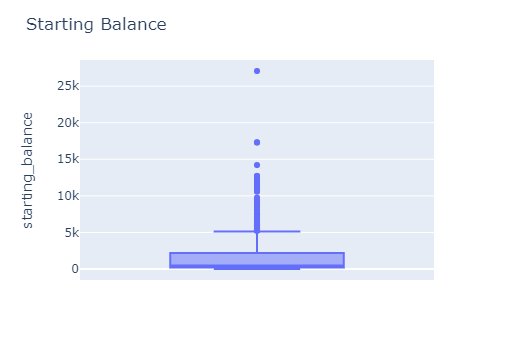

In [12]:
fig = px.box(accounts, y='starting_balance')
fig.update_layout(title_text='Starting Balance')
fig.show()

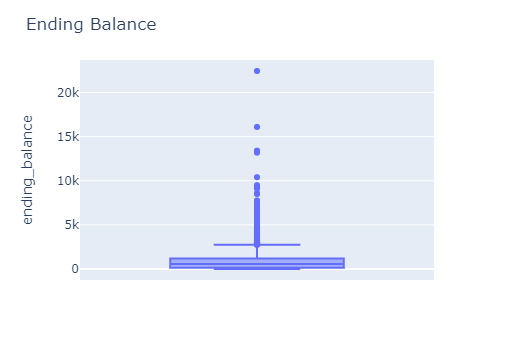

In [13]:
fig = px.box(accounts, y='ending_balance')
fig.update_layout(title_text='Ending Balance')
fig.show()

Kinda hard to see with all these outliers. Let's try segregating by account type and see what happens.

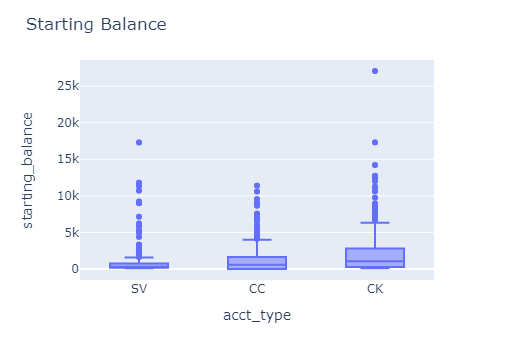

In [14]:
fig = px.box(accounts, y='starting_balance', x='acct_type')
fig.update_layout(title_text='Starting Balance')
fig.show()

These look like the savings, credit, and chequing accounts.

Let's look at the difference between starting the account and the latest balance

## Finding Debt
In order to find out if someone is in debt, we'll add up their savings and chequing accounts and subtract their credit. A positive amount denotes no debt, and a negative one denotes debt.
First, get a column of the unique customer id's from accounts. We will be merging in three tables to get customer's total bank amounts.
Make three separate tables, each for the savings, chequing, and credit accounts. Find an account's chequing balance by left inner joining chequing with savings. Add up the balances to find the total balance. Then, perform another left inner join with the credit account, fill Nans, and subtract that amount from the total balance to find their debt.

In [15]:
savings_debt = pd.DataFrame(accounts['cust_id'].unique(), columns=['cust_id'])

In [16]:
savings_debt

cust_id
0    1362806
1    1362709
2    1362836
3    1363311
4    1363361
..       ...
660  1363044
661  1362714
662  1362668
663  1362893
664  1362654

[665 rows x 1 columns]

Find all the different account types and name their columns

In [17]:
savings = accounts[accounts['acct_type'] == 'SV'][['cust_id', 'ending_balance']]
savings.columns = ['cust_id', 'savings_balance']
chequing = accounts[accounts['acct_type'] == 'CK'][['cust_id', 'ending_balance']]
chequing.columns = ['cust_id', 'chequing_balance']
credit = accounts[accounts['acct_type'] == 'CC'][['cust_id', 'ending_balance']]
credit.columns = ['cust_id', 'credit_balance']

Left inner join on the total list of customers to get all of their accounts side by side. Customers who don't have a particular account will have NaN in that row, later fill that in with a 0.

In [18]:
savings_debt = pd.merge(savings_debt, savings, on='cust_id', how='left')

In [19]:
savings_debt = pd.merge(savings_debt, chequing, on='cust_id', how='left')

In [20]:
savings_debt = pd.merge(savings_debt, credit, on='cust_id', how='left')

Fill nans with 0's

In [21]:
savings_debt = savings_debt.fillna(0)

In [22]:
savings_debt.head()

cust_id  savings_balance  chequing_balance  credit_balance
0  1362806           284.58           2561.24         1541.64
1  1362709           917.33            185.90          496.15
2  1362836          1009.19              7.72         1000.00
3  1363311           299.67            968.46         2700.00
4  1363361           172.80             21.54          462.28

Add up the savings balance and the chequing balance

In [23]:
savings_debt['total_balance'] = savings_debt['chequing_balance'] + savings_debt['savings_balance']

Find the debt by subtracting credit from the total

In [24]:
savings_debt['net'] = savings_debt['total_balance'] - savings_debt['credit_balance']

In [25]:
savings_debt.describe()

cust_id  savings_balance  chequing_balance  credit_balance  \
count  6.650000e+02       665.000000        665.000000      665.000000   
mean   1.362990e+06       796.456496        513.371128      833.874421   
std    2.954503e+02      1743.146828       1048.056237     1264.855285   
min    1.362480e+06         0.000000          0.000000        0.000000   
25%    1.362727e+06         0.000000          2.720000        0.000000   
50%    1.362991e+06       201.950000        117.930000      457.290000   
75%    1.363249e+06       896.450000        554.350000     1000.000000   
max    1.363495e+06     22432.780000      13185.470000     9500.000000   

       total_balance           net  
count     665.000000    665.000000  
mean     1309.827624    475.953203  
std      2136.716922   2376.674863  
min         0.000000  -9153.520000  
25%       156.320000   -523.080000  
50%       613.090000    165.580000  
75%      1657.080000   1080.760000  
max     26792.610000  26772.610000

Finally, merge the dummy variables extracted earlier with the savings_debt table

In [26]:
savings_debt = pd.merge(savings_debt, accounts_dummy, on='cust_id')

In [27]:
savings_debt.isnull().sum()

cust_id             0
savings_balance     0
chequing_balance    0
credit_balance      0
total_balance       0
net                 0
acct_type_CC        0
acct_type_CK        0
acct_type_SV        0
dtype: int64

## Finding Transaction Behaviour
Count the transactions that each account makes, and take the average amount of their transactions

First, lets get each customer's savings transactions

In [28]:
savings_tran = pd.read_csv('data/twm_savings_tran.csv', sep=';')

Get the savings total for each customer

In [29]:
savings_tot = pd.DataFrame(savings_tran.groupby(['cust_id']).sum()['principal_amt'])
savings_tot.columns = ['sav_tran_avg']

Find a customer's total amount of transactions made

In [30]:
savings_num = pd.DataFrame(savings_tran.groupby(['cust_id']).count()['tran_id'])
savings_num.columns = ['sav_tran_cnt']

In [31]:
savings_tot = pd.merge(savings_tot, savings_num, on='cust_id')

In [32]:
savings_tot['sav_tran_avg'] = savings_tot['sav_tran_avg'] / savings_tot['sav_tran_cnt']

Merge with the savings_debt dataframe

In [33]:
savings_debt = pd.merge(savings_debt, savings_tot, on='cust_id', how='left')

Now do the same with chequing and credit

In [34]:
cheq_tran = pd.read_csv('data/twm_checking_tran.csv', sep=';')

Get the chequing total for each customer

In [35]:
cheq_tot = pd.DataFrame(cheq_tran.groupby(['cust_id']).sum()['principal_amt'])
cheq_tot.columns = ['cheq_tran_avg']

Find a customer's total amount of transactions made

In [36]:
cheq_num = pd.DataFrame(cheq_tran.groupby(['cust_id']).count()['tran_id'])
cheq_num.columns = ['cheq_tran_cnt']

In [37]:
cheq_tot = pd.merge(cheq_tot, cheq_num, on='cust_id')

Find the customer's average transactions

In [38]:
cheq_tot['cheq_tran_avg'] = cheq_tot['cheq_tran_avg'] / cheq_tot['cheq_tran_cnt']

In [39]:
cheq_tot.head()

cheq_tran_avg  cheq_tran_cnt
cust_id                              
1362480      -2.474646             99
1362484     -25.446667             99
1362485      -1.659495             99
1362486     -39.808800             25
1362487     -27.106731             52

Merge with the savings_debt dataframe

In [40]:
savings_debt = pd.merge(savings_debt, cheq_tot, on='cust_id', how='left')

In [41]:
savings_debt.head()

cust_id  savings_balance  chequing_balance  credit_balance  total_balance  \
0  1362806           284.58           2561.24         1541.64        2845.82   
1  1362709           917.33            185.90          496.15        1103.23   
2  1362836          1009.19              7.72         1000.00        1016.91   
3  1363311           299.67            968.46         2700.00        1268.13   
4  1363361           172.80             21.54          462.28         194.34   

       net  acct_type_CC  acct_type_CK  acct_type_SV  sav_tran_avg  \
0  1304.18             1             1             1    -29.654500   
1   607.08             1             1             1     19.463500   
2    16.91             1             1             1     17.037556   
3 -1431.87             1             1             1    -12.715926   
4  -267.94             1             1             1     -1.722000   

   sav_tran_cnt  cheq_tran_avg  cheq_tran_cnt  
0          40.0      23.664343           99.0  
1          40.0     -20.941515           99.0  
2          45.0      -2.148384           99.0  
3          27.0    -102.479798           99.0  
4          15.0     -36.654646           99.0

First, lets get each customer's credit transactions

In [42]:
cred_tran = pd.read_csv('data/twm_credit_tran.csv', sep=';')

Get the credit total for each customer

In [43]:
cred_tot = pd.DataFrame(savings_tran.groupby(['cust_id']).sum()['principal_amt'])
cred_tot.columns = ['cred_tran_avg']

Find a customer's total amount of transactions made

In [44]:
cred_num = pd.DataFrame(cred_tran.groupby(['cust_id']).count()['tran_id'])
cred_num.columns = ['cred_tran_cnt']

In [45]:
cred_tot = pd.merge(cred_tot, cred_num, on='cust_id')

Find the customer's average transactions

In [46]:
cred_tot['cred_tran_avg'] = cred_tot['cred_tran_avg'] / cred_tot['cred_tran_cnt']

Merge with the savings_debt dataframe

In [47]:
savings_debt = pd.merge(savings_debt, cred_tot, on='cust_id', how='left')

In [48]:
savings_debt

cust_id  savings_balance  chequing_balance  credit_balance  \
0    1362806           284.58           2561.24         1541.64   
1    1362709           917.33            185.90          496.15   
2    1362836          1009.19              7.72         1000.00   
3    1363311           299.67            968.46         2700.00   
4    1363361           172.80             21.54          462.28   
..       ...              ...               ...             ...   
660  1363044             0.00              0.00          523.08   
661  1362714             0.00              0.00          457.29   
662  1362668          1470.67              0.00            0.00   
663  1362893           976.43              0.00            0.00   
664  1362654           622.46              0.00            0.00   

     total_balance      net  acct_type_CC  acct_type_CK  acct_type_SV  \
0          2845.82  1304.18             1             1             1   
1          1103.23   607.08             1             1             1   
2          1016.91    16.91             1             1             1   
3          1268.13 -1431.87             1             1             1   
4           194.34  -267.94             1             1             1   
..             ...      ...           ...           ...           ...   
660           0.00  -523.08             1             0             0   
661           0.00  -457.29             1             0             0   
662        1470.67  1470.67             0             0             1   
663         976.43   976.43             0             0             1   
664         622.46   622.46             0             0             1   

     sav_tran_avg  sav_tran_cnt  cheq_tran_avg  cheq_tran_cnt  cred_tran_avg  \
0      -29.654500          40.0      23.664343           99.0     -17.191014   
1       19.463500          40.0     -20.941515           99.0      14.155273   
2       17.037556          45.0      -2.148384           99.0      18.699756   
3      -12.715926          27.0    -102.479798           99.0     -28.610833   
4       -1.722000          15.0     -36.654646           99.0      -0.600698   
..            ...           ...            ...            ...            ...   
660           NaN           NaN            NaN            NaN            NaN   
661           NaN           NaN            NaN            NaN            NaN   
662     31.063000          40.0            NaN            NaN            NaN   
663     30.955909          22.0            NaN            NaN            NaN   
664     -8.897619          21.0            NaN            NaN            NaN   

     cred_tran_cnt  
0             69.0  
1             55.0  
2             41.0  
3             12.0  
4             43.0  
..             ...  
660            NaN  
661            NaN  
662            NaN  
663            NaN  
664            NaN  

[665 rows x 15 columns]

Fill in the NaN values with 0's

In [49]:
savings_debt = savings_debt.fillna(0)

In [50]:
savings_debt

cust_id  savings_balance  chequing_balance  credit_balance  \
0    1362806           284.58           2561.24         1541.64   
1    1362709           917.33            185.90          496.15   
2    1362836          1009.19              7.72         1000.00   
3    1363311           299.67            968.46         2700.00   
4    1363361           172.80             21.54          462.28   
..       ...              ...               ...             ...   
660  1363044             0.00              0.00          523.08   
661  1362714             0.00              0.00          457.29   
662  1362668          1470.67              0.00            0.00   
663  1362893           976.43              0.00            0.00   
664  1362654           622.46              0.00            0.00   

     total_balance      net  acct_type_CC  acct_type_CK  acct_type_SV  \
0          2845.82  1304.18             1             1             1   
1          1103.23   607.08             1             1             1   
2          1016.91    16.91             1             1             1   
3          1268.13 -1431.87             1             1             1   
4           194.34  -267.94             1             1             1   
..             ...      ...           ...           ...           ...   
660           0.00  -523.08             1             0             0   
661           0.00  -457.29             1             0             0   
662        1470.67  1470.67             0             0             1   
663         976.43   976.43             0             0             1   
664         622.46   622.46             0             0             1   

     sav_tran_avg  sav_tran_cnt  cheq_tran_avg  cheq_tran_cnt  cred_tran_avg  \
0      -29.654500          40.0      23.664343           99.0     -17.191014   
1       19.463500          40.0     -20.941515           99.0      14.155273   
2       17.037556          45.0      -2.148384           99.0      18.699756   
3      -12.715926          27.0    -102.479798           99.0     -28.610833   
4       -1.722000          15.0     -36.654646           99.0      -0.600698   
..            ...           ...            ...            ...            ...   
660      0.000000           0.0       0.000000            0.0       0.000000   
661      0.000000           0.0       0.000000            0.0       0.000000   
662     31.063000          40.0       0.000000            0.0       0.000000   
663     30.955909          22.0       0.000000            0.0       0.000000   
664     -8.897619          21.0       0.000000            0.0       0.000000   

     cred_tran_cnt  
0             69.0  
1             55.0  
2             41.0  
3             12.0  
4             43.0  
..             ...  
660            0.0  
661            0.0  
662            0.0  
663            0.0  
664            0.0  

[665 rows x 15 columns]

In [51]:
savings_debt.describe()

cust_id  savings_balance  chequing_balance  credit_balance  \
count  6.650000e+02       665.000000        665.000000      665.000000   
mean   1.362990e+06       796.456496        513.371128      833.874421   
std    2.954503e+02      1743.146828       1048.056237     1264.855285   
min    1.362480e+06         0.000000          0.000000        0.000000   
25%    1.362727e+06         0.000000          2.720000        0.000000   
50%    1.362991e+06       201.950000        117.930000      457.290000   
75%    1.363249e+06       896.450000        554.350000     1000.000000   
max    1.363495e+06     22432.780000      13185.470000     9500.000000   

       total_balance           net  acct_type_CC  acct_type_CK  acct_type_SV  \
count     665.000000    665.000000    665.000000    665.000000    665.000000   
mean     1309.827624    475.953203      0.703759      0.781955      0.633083   
std      2136.716922   2376.674863      0.456942      0.413229      0.482326   
min         0.000000  -9153.520000      0.000000      0.000000      0.000000   
25%       156.320000   -523.080000      0.000000      1.000000      0.000000   
50%       613.090000    165.580000      1.000000      1.000000      1.000000   
75%      1657.080000   1080.760000      1.000000      1.000000      1.000000   
max     26792.610000  26772.610000      1.000000      1.000000      1.000000   

       sav_tran_avg  sav_tran_cnt  cheq_tran_avg  cheq_tran_cnt  \
count    665.000000    665.000000     665.000000     665.000000   
mean       7.537409     16.825564     -13.253172      69.479699   
std       25.670079     15.578105      24.585282      41.847399   
min      -95.077692      0.000000    -174.515758       0.000000   
25%        0.000000      0.000000     -24.413737      24.000000   
50%        0.000000     16.000000      -2.076263      99.000000   
75%        8.965526     28.000000       0.000000      99.000000   
max      195.668545     62.000000      63.594074      99.000000   

       cred_tran_avg  cred_tran_cnt  
count     665.000000     665.000000  
mean        5.436588      18.419549  
std        40.155335      25.301315  
min       -80.652500       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000      38.000000  
max       900.820000     137.000000

In [52]:
savings_debt.isnull().sum()

cust_id             0
savings_balance     0
chequing_balance    0
credit_balance      0
total_balance       0
net                 0
acct_type_CC        0
acct_type_CK        0
acct_type_SV        0
sav_tran_avg        0
sav_tran_cnt        0
cheq_tran_avg       0
cheq_tran_cnt       0
cred_tran_avg       0
cred_tran_cnt       0
dtype: int64

# Clustering the Data
Cluster the data using K-Means. Then, visualize the clustering using plotly's radar plot.

In [53]:
# turn the cust_id into string so it doesn't get scaled or used in clustering
savings_debt = savings_debt.set_index('cust_id')
# savings_debt['cust_id'] = savings_debt['cust_id'].to_string()

In [54]:
# import k-means
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Use the elbow method to find the optimal number of clusters

In [55]:
cluster_data = savings_debt[['savings_balance', 'chequing_balance','credit_balance', 
                             'total_balance', 'net', 'sav_tran_avg', 
                             'sav_tran_cnt', 'cred_tran_avg', 'cred_tran_cnt']]

In [56]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cluster_data)
    distortions.append(kmeanModel.inertia_)

C:\Users\engwb\anaconda3\envs\plotly-env\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.



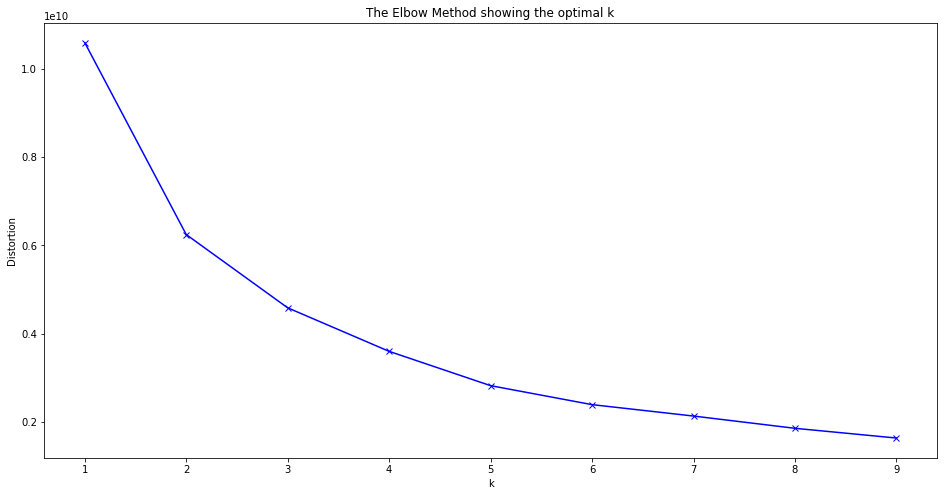

In [57]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

There doesn't seem to be a very definitive elbow, but it does seem to have one at 3 so i'll select 3 for the clusters 

In [58]:
km = KMeans(n_clusters=4, random_state=0)

In [59]:
y_km = km.fit_predict(cluster_data)

In [60]:
cluster_data['cluster'] = y_km.tolist()

C:\Users\engwb\anaconda3\envs\plotly-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [61]:
cluster_data.head()

savings_balance  chequing_balance  credit_balance  total_balance  \
cust_id                                                                     
1362806           284.58           2561.24         1541.64        2845.82   
1362709           917.33            185.90          496.15        1103.23   
1362836          1009.19              7.72         1000.00        1016.91   
1363311           299.67            968.46         2700.00        1268.13   
1363361           172.80             21.54          462.28         194.34   

             net  sav_tran_avg  sav_tran_cnt  cred_tran_avg  cred_tran_cnt  \
cust_id                                                                      
1362806  1304.18    -29.654500          40.0     -17.191014           69.0   
1362709   607.08     19.463500          40.0      14.155273           55.0   
1362836    16.91     17.037556          45.0      18.699756           41.0   
1363311 -1431.87    -12.715926          27.0     -28.610833           12.0   
1363361  -267.94     -1.722000          15.0      -0.600698           43.0   

         cluster  
cust_id           
1362806        0  
1362709        1  
1362836        1  
1363311        1  
1363361        1

In [62]:
cluster_data['cluster'] = cluster_data['cluster'].astype(str)

C:\Users\engwb\anaconda3\envs\plotly-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
cluster_data.groupby('cluster').count()

savings_balance  chequing_balance  credit_balance  total_balance  \
cluster                                                                     
0                    137               137             137            137   
1                    475               475             475            475   
2                     39                39              39             39   
3                     14                14              14             14   

         net  sav_tran_avg  sav_tran_cnt  cred_tran_avg  cred_tran_cnt  
cluster                                                                 
0        137           137           137            137            137  
1        475           475           475            475            475  
2         39            39            39             39             39  
3         14            14            14             14             14

In [64]:
cluster_avg = cluster_data.groupby('cluster').mean()

In [65]:
cluster_avg

savings_balance  chequing_balance  credit_balance  total_balance  \
cluster                                                                     
0            1834.513139       1196.334380      679.327007    3030.847518   
1             275.335389        253.703684      570.491537     529.039074   
2             564.341538        460.931282     4606.391795    1025.272821   
3            8965.831429       2786.315714      773.280714   11752.147143   

                  net  sav_tran_avg  sav_tran_cnt  cred_tran_avg  \
cluster                                                            
0         2351.520511     24.213999     24.817518      18.611507   
1          -41.452463      1.865847     14.362105       1.196674   
2        -3581.118974      4.178746     14.410256       4.863404   
3        10978.866429     46.129355     28.928571      21.961558   

         cred_tran_cnt  
cluster                 
0            26.021898  
1            15.795789  
2            20.025641  
3            28.571429

In [66]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

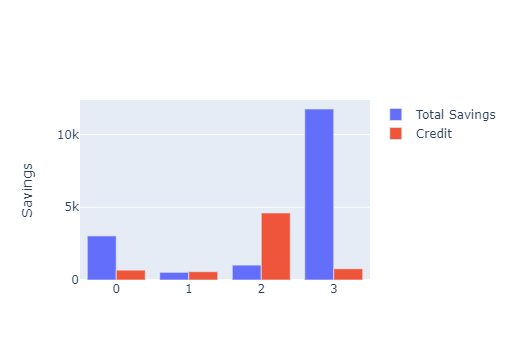

In [67]:
fig = go.Figure(data=[
    go.Bar(name='Total Savings', x=cluster_avg.index, y=cluster_avg['total_balance'], 
           offsetgroup=1),
    go.Bar(name='Credit', x=cluster_avg.index, y=cluster_avg['credit_balance'],
          offsetgroup=2)],
               layout={
                   'yaxis': {'title': 'Savings'},
                   'yaxis2': {'title': 'Credit', 'overlaying': 'y', 'side': 'right'}
               })
fig.update_layout(barmode='group')
fig.show()

In [68]:
radial_data = cluster_avg[['savings_balance', 'chequing_balance', 'credit_balance', 'total_balance']]

In [69]:
radial_data.iloc[0]

savings_balance     1834.513139
chequing_balance    1196.334380
credit_balance       679.327007
total_balance       3030.847518
Name: 0, dtype: float64

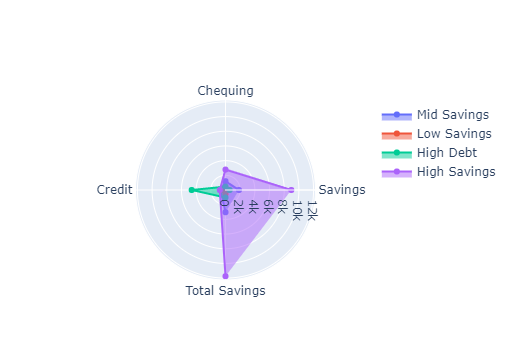

In [123]:
theta = ['Savings', 'Chequing', 'Credit', 'Total Savings']
btype =['Mid Savings', 'Low Savings', 'High Debt', 'High Savings']
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=radial_data.iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i]
    ))
fig.show()

# PCA

First, standardize the data

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
x = cluster_data.loc[:, ~cluster_data.columns.isin(['cluster'])].values
y = cluster_data.reset_index()['cluster']

In [73]:
scaler = StandardScaler()

In [74]:
x = scaler.fit_transform(x)

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['PC1', 
                                      'PC2'])

In [76]:
cluster_data['cluster']

cust_id
1362806    0
1362709    1
1362836    1
1363311    1
1363361    1
          ..
1363044    1
1362714    1
1362668    1
1362893    1
1362654    1
Name: cluster, Length: 665, dtype: object

In [77]:
principalDf

PC1       PC2
0    1.056502  1.631520
1    0.796601  1.573110
2    0.611785  1.685053
3   -0.722599  0.994030
4   -0.690672  0.649275
..        ...       ...
660 -1.383675 -0.817634
661 -1.369478 -0.850709
662  0.860464 -0.060760
663  0.194845 -0.539208
664 -0.576644 -0.536117

[665 rows x 2 columns]

In [78]:
finalDf = pd.concat((principalDf, y), axis=1)

In [79]:
finalDf

PC1       PC2 cluster
0    1.056502  1.631520       0
1    0.796601  1.573110       1
2    0.611785  1.685053       1
3   -0.722599  0.994030       1
4   -0.690672  0.649275       1
..        ...       ...     ...
660 -1.383675 -0.817634       1
661 -1.369478 -0.850709       1
662  0.860464 -0.060760       1
663  0.194845 -0.539208       1
664 -0.576644 -0.536117       1

[665 rows x 3 columns]

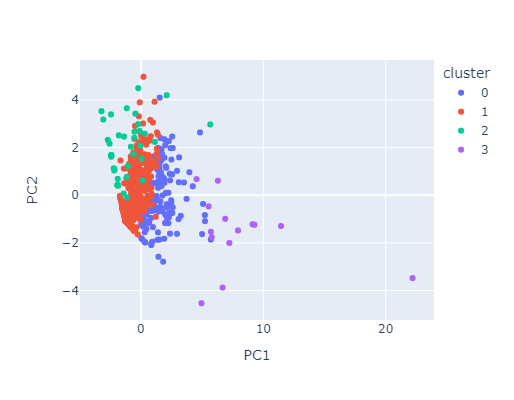

In [80]:
px.scatter(finalDf, x='PC1', y='PC2', color='cluster', width=600, height=400)

# Separating by Region

In [82]:
cluster_data.head()

savings_balance  chequing_balance  credit_balance  total_balance  \
cust_id                                                                     
1362806           284.58           2561.24         1541.64        2845.82   
1362709           917.33            185.90          496.15        1103.23   
1362836          1009.19              7.72         1000.00        1016.91   
1363311           299.67            968.46         2700.00        1268.13   
1363361           172.80             21.54          462.28         194.34   

             net  sav_tran_avg  sav_tran_cnt  cred_tran_avg  cred_tran_cnt  \
cust_id                                                                      
1362806  1304.18    -29.654500          40.0     -17.191014           69.0   
1362709   607.08     19.463500          40.0      14.155273           55.0   
1362836    16.91     17.037556          45.0      18.699756           41.0   
1363311 -1431.87    -12.715926          27.0     -28.610833           12.0   
1363361  -267.94     -1.722000          15.0      -0.600698           43.0   

        cluster  
cust_id          
1362806       0  
1362709       1  
1362836       1  
1363311       1  
1363361       1

In [98]:
regions = pd.read_csv('data/updated_customers.csv')

In [99]:
regions = regions[['cust_id', 'General_Region']]

In [104]:
regions

cust_id General_Region
0    1362691           West
1    1362487           West
2    1363160           West
3    1362752           West
4    1362548           East
..       ...            ...
742  1363324           West
743  1362895           East
744  1362569           West
745  1363364          South
746  1363303           West

[747 rows x 2 columns]

In [126]:
radial_region_data = cluster_data[['savings_balance', 'chequing_balance',
                                  'credit_balance', 'total_balance', 'cluster']]
# radial_region_data = radial_region_data.merge(regions, on=index)

In [127]:
radial_region_data = radial_region_data.reset_index()

In [128]:
radial_region_data = radial_region_data.merge(regions)

In [129]:
radial_region_data = radial_region_data.drop('cust_id', axis=1)

In [130]:
radial_region_data

savings_balance  chequing_balance  credit_balance  total_balance cluster  \
0             284.58           2561.24         1541.64        2845.82       0   
1             917.33            185.90          496.15        1103.23       1   
2            1009.19              7.72         1000.00        1016.91       1   
3             299.67            968.46         2700.00        1268.13       1   
4             172.80             21.54          462.28         194.34       1   
..               ...               ...             ...            ...     ...   
660             0.00              0.00          523.08           0.00       1   
661             0.00              0.00          457.29           0.00       1   
662          1470.67              0.00            0.00        1470.67       1   
663           976.43              0.00            0.00         976.43       1   
664           622.46              0.00            0.00         622.46       1   

    General_Region  
0          Midwest  
1             West  
2            South  
3             West  
4             West  
..             ...  
660           East  
661        Midwest  
662           West  
663           West  
664          South  

[665 rows x 6 columns]

In [133]:
region_avg = radial_region_data.groupby('General_Region').mean()

In [134]:
region_avg

savings_balance  chequing_balance  credit_balance  \
General_Region                                                      
East                 856.539456        522.991565      842.223265   
Midwest              892.064812        609.371654      812.393684   
Other                371.178000         29.961000      699.264000   
South                783.003007        521.555490      940.606732   
West                 727.821667        465.621667      773.720000   

                total_balance  
General_Region                 
East              1379.531020  
Midwest           1501.436466  
Other              401.139000  
South             1304.558497  
West              1193.443333

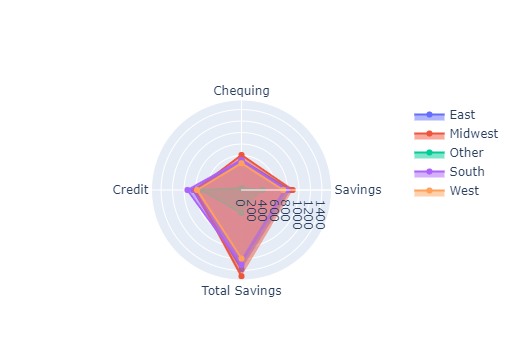

In [135]:
theta = ['Savings', 'Chequing', 'Credit', 'Total Savings']
region = ['East', 'Midwest', 'Other', 'South', 'West']
fig = go.Figure()
for i in range(0, len(region)):
    fig.add_trace(go.Scatterpolar(
          r=region_avg.iloc[i],
          theta=theta,
          fill='toself',
          name=region[i]
    ))
fig.show()

# Clusters for each region

savings_balance  chequing_balance  credit_balance  total_balance
cluster                                                                  
0            1958.865556       1421.953889      774.210278    3380.819444
1             257.002115        230.030962      751.367981     487.033077
2             415.120000         82.170000     4448.245000     497.290000
3            9001.146667        479.173333        0.000000    9480.320000

In [144]:
regions = []

In [145]:
regions.append(radial_region_data[radial_region_data['General_Region'] == 'East'].groupby('cluster').mean())
regions.append(radial_region_data[radial_region_data['General_Region'] == 'Midwest'].groupby('cluster').mean())
# regions.append(radial_region_data[radial_region_data['General_Region'] == 'Other'].groupby('cluster').mean())
regions.append(radial_region_data[radial_region_data['General_Region'] == 'South'].groupby('cluster').mean())
regions.append(radial_region_data[radial_region_data['General_Region'] == 'West'].groupby('cluster').mean())

In [172]:
regions[2]

savings_balance  chequing_balance  credit_balance  total_balance
cluster                                                                  
0              2301.5300           0.00000            0.00     2301.53000
1               170.1075          35.52875          499.08      205.63625
2                49.3900          15.38000         3000.00       64.77000

In [153]:
len(regions)

5

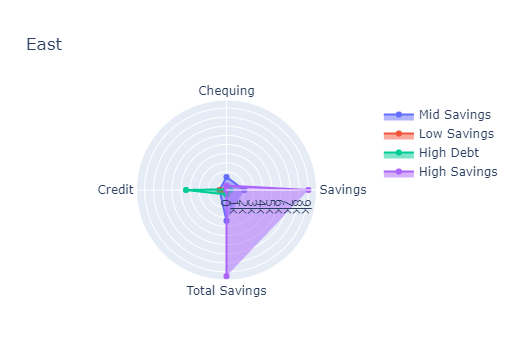

In [162]:
theta = ['Savings', 'Chequing', 'Credit', 'Total Savings']
region = ['East', 'Midwest', 'Other', 'South', 'West']
btype =['Mid Savings', 'Low Savings', 'High Debt', 'High Savings']
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=regions[0].iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i],
    ))
fig.update_layout(title=region[0])
fig.show()

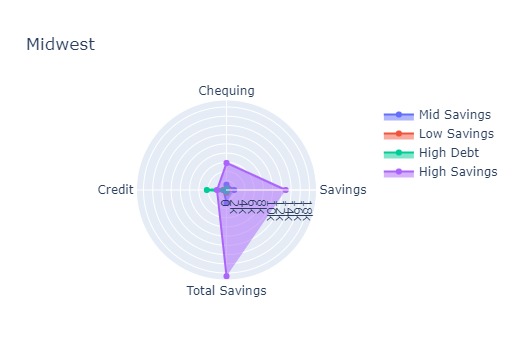

In [163]:
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=regions[1].iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i],
    ))
fig.update_layout(title=region[1])
fig.show()

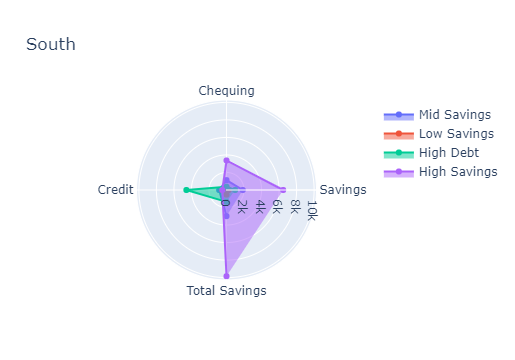

In [164]:
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=regions[3].iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i],
    ))
fig.update_layout(title=region[3])
fig.show()

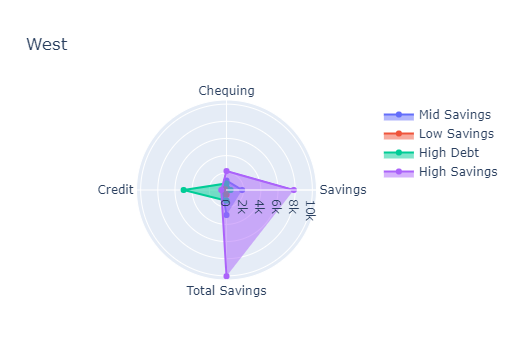

In [165]:
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=regions[4].iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i],
    ))
fig.update_layout(title=region[4])
fig.show()

In [173]:
fig = go.Figure()
for i in range(0, len(theta)):
    fig.add_trace(go.Scatterpolar(
          r=regions[2].iloc[i],
          theta=theta,
          fill='toself',
          name=btype[i],
    ))
fig.update_layout(title=region[2])
fig.show()

IndexError: single positional indexer is out-of-bounds